# Imaging using TFM and FWI

Lars Gebraad

_Copyright Mondaic AG, for the University of Bristol, January 2025._

This tutorial will showcase various imaging approaches with Salvus as the engine. Please note that we at Salvus are not experts at TFM iamging, so our implementations can probably be improved

In [81]:
import dataclasses

import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Main Salvus import
import salvus.namespace as sn

import salvus.mesh
import salvus.mesh.layered_meshing as lm

Please change to be appropriate for your machine:

In [85]:
SITE_NAME = "local"
RANKS = 8

# 1 MHz should run on laptops, 4 MHz and higher we recommend GPUs
CENTRAL_FREQUENCY = 1.5e6  # MHz

assert CENTRAL_FREQUENCY >= 1.5e6

PROJECT_NAME = f"project_04_{int(CENTRAL_FREQUENCY)}"

## Creating the domain, project, mesh, simulations and events

We'll start with a simple 2D domain, and create a project from it.

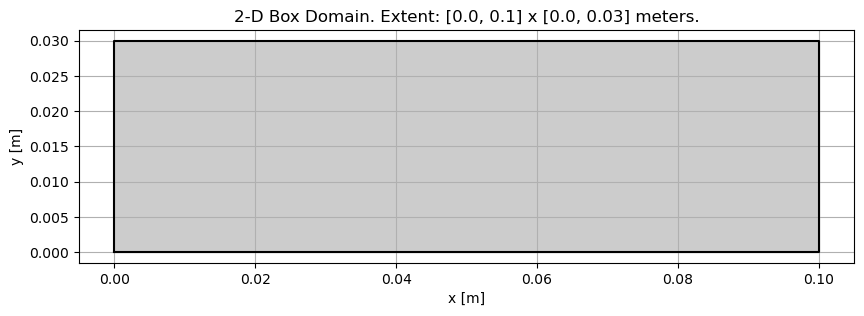

In [86]:
x0, x1 = 0.0, 0.1
y0, y1 = 0.0, 0.03

domain = sn.domain.dim2.BoxDomain(x0=x0, x1=x1, y0=y0, y1=y1)

domain.plot()

In [87]:
# Once we have a domain we can initialize a project with a path on disk.
p = sn.Project.from_domain(
    path=PROJECT_NAME, domain=domain, load_if_exists=True
)

Accordion()

Next, we use Salvus' **layered meshing** to create a (for now unlayered) model, with absorbing boundaries on all but one side, and 3 scatterers.

In [88]:
homogeneous_model = lm.LayeredModel(
    [
        sn.material.acoustic.Velocity.from_params(rho=2600.0, vp=5000.0),
    ]
)

homogeneous_model_ab = sn.layered_meshing.MeshingProtocol(
    homogeneous_model,
    ab=salvus.mesh.simple_mesh.basic_mesh.AbsorbingBoundaryParameters(
        free_surface=["y1"],
        number_of_wavelengths=1.5,
        reference_velocity=5000,
        reference_frequency=CENTRAL_FREQUENCY * 2,
    ),
)

mesh_homogeneous = lm.mesh_from_domain(
    domain=domain,
    model=homogeneous_model_ab,
    mesh_resolution=sn.MeshResolution(
        reference_frequency=CENTRAL_FREQUENCY * 2, elements_per_wavelength=2
    ),
)

# Make a copy to add strong scatterers after meshing
mesh_homogeneous_scatterers = mesh_homogeneous.copy()
for scatterer_center in [np.array([x, 0.01]) for x in [0.03, 0.05, 0.07]]:
    distance_from_scatterer = np.linalg.norm(
        mesh_homogeneous_scatterers.get_element_centroid() - scatterer_center,
        axis=1,
    )
    radius = 0.00125
    anomaly = distance_from_scatterer < radius
    mesh_homogeneous_scatterers.elemental_fields["RHO"] -= (
        anomaly[:, None] * 2400
    )
    mesh_homogeneous_scatterers.elemental_fields["VP"] -= (
        anomaly[:, None] * 500
    )

mesh_homogeneous_scatterers

Now, let's add this mesh, together with a source time function and some other parameters, as a simulation:

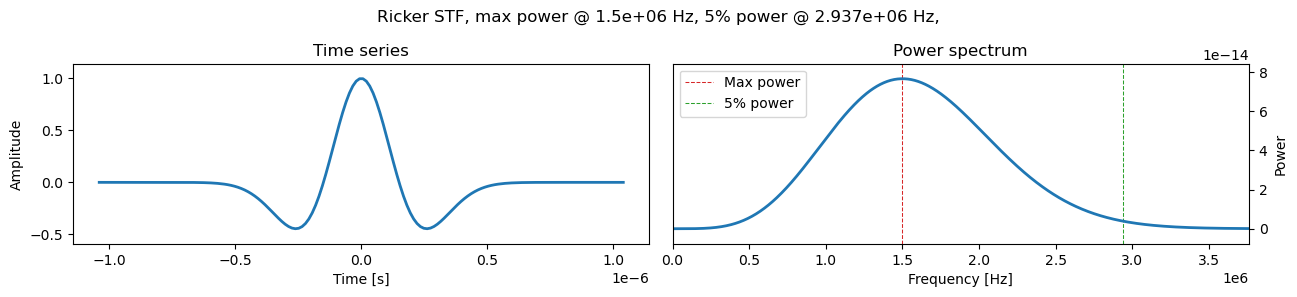

In [89]:
stf = sn.simple_config.stf.Ricker(center_frequency=CENTRAL_FREQUENCY)

stf.plot()

end_time = 5e-5

sc = sn.UnstructuredMeshSimulationConfiguration(
    unstructured_mesh=mesh_homogeneous_scatterers,
    name="sc_mesh_homogeneous",
    # Event specific configuration.
    event_configuration=sn.EventConfiguration(
        # Source wavelet.
        wavelet=stf,
        waveform_simulation_configuration=sn.WaveformSimulationConfiguration(
            end_time_in_seconds=end_time
        ),
    ),
)

p += sc

Here is a version of the array transducers in 2D, which is specialised for acoustic. 

If you want to adapt this to other settings, make sure to choose the appropriate sources and receivers for the type of material you are using (elastic or acoustic).

In [90]:
@dataclasses.dataclass
class ArrayTransducer2D:
    # Represents a rectangular array transducer.
    nx: int
    dx: float
    x0: float

    # Update this per array if you want to add multiple, as the
    # receivers will use this name to identify themselves
    array_name: str = "array_0"

    # Note that because these are placed in an acoustic medium, they
    # must record one of the acoustic fields!
    recording_fields: list[str] = dataclasses.field(
        default_factory=lambda: ["phi"]
    )

    # Determines on what side of the domain the array is attached
    side_set: str = "y1"

    def test_within_domain(self, domain: sn.domain.Domain) -> bool:
        # Determines whether the entire grid of the array transducer
        # is within a given domain.
        x_bounds = domain.bounds.hc["x"]

        # Calculate the spatial bounds of the array transducer
        array_x_bounds = (self.x0, self.x0 + (self.nx - 1) * self.dx)

        # Check if the array is fully within the domain bounds
        within_x = (
            x_bounds[0] <= array_x_bounds[0]
            and array_x_bounds[1] <= x_bounds[1]
        )

        return within_x

    def create_salvus_source_receivers(
        self,
        source_index: int,
        f_source: int = 1,
    ):
        # Function to create salvus sources and receivers from array
        if source_index < 0 or source_index > self.nx - 1:
            raise ValueError("Source index out of range.")

        array_coordinates = np.zeros((self.nx))
        for i in range(self.nx):
            array_coordinates[i] = self.x0 + i * self.dx

        # Calculate all sources
        source_x = array_coordinates[source_index]

        source = sn.simple_config.source.cartesian.SideSetScalarPoint2D(
            # Note that this 0 for Y is used for starting the projection
            # on the side set, it is not the coordinate of the source.
            point=(source_x, 0),
            f=f_source,
            direction="y",
            side_set_name=self.side_set,
        )

        receivers = [
            sn.simple_config.receiver.cartesian.SideSetPoint2D(
                direction="y",
                point=(
                    array_coordinates[i],
                    0,
                ),
                # Note that we're using leading zeros, but if nx/ny is
                # really high this needs to be scaled up.
                station_code=f"{self.array_name}_x{i:03d}",
                fields=self.recording_fields,
                side_set_name=self.side_set,
            )
            for i in range(self.nx)
        ]

        return source, receivers

Let's create one array with a 100 transducers.

In [91]:
nx = 100

array_1 = ArrayTransducer2D(
    nx=nx, x0=10e-3, dx=0.08 / nx, array_name="array_0"
)

array_1.test_within_domain(domain)

True

And generate the Salvus sources and receivers for source position 14.

In [92]:
source_id = 14

source, receivers = array_1.create_salvus_source_receivers(
    source_index=source_id
)

event = sn.Event(
    event_name=f"array_a_source_{source_id}",
    sources=source,
    receivers=receivers,
)

p += event

With events and simulation configurations defined, we can finally visualize our setup completely:

In [93]:
p.simulations.list()

['sc_mesh_homogeneous']

In [94]:
source_id = 14

p.viz.nb.simulation_setup(
    simulation_configuration="sc_mesh_homogeneous",
    events=f"array_a_source_{source_id}",
)

Locating 100 item(s)::   0%|          | 0/100 [00:00<?, ?it/s]

## Simulating 'observed' data and imaging using TFM

Let's first run this event.

In [95]:
source_id = 14
p.simulations.launch(
    simulation_configuration="sc_mesh_homogeneous",
    events=f"array_a_source_{source_id}",
    site_name=SITE_NAME,
    ranks_per_job=RANKS,
    delete_conflicting_previous_results=True,
)

p.simulations.query(block=True)

Locating 100 item(s)::   0%|          | 0/100 [00:00<?, ?it/s]

[2025-02-02 18:10:29,709] INFO: Submitting job ...
Uploading 1 files...

🚀  Submitted job_2502021810715158_57fd66c30e@local


VBox()

True

Visualizing the data for this event/shot/source can be easily done by getting the **xarray** data and using its plot function.

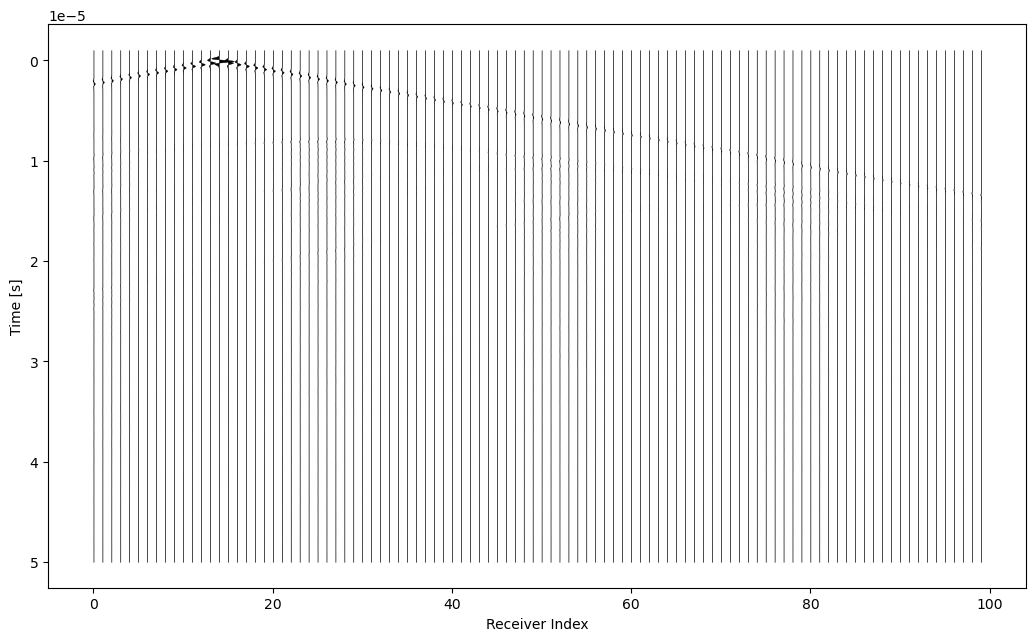

In [96]:
source_id = 14

event_data = p.waveforms.get(
    "sc_mesh_homogeneous", f"array_a_source_{source_id}"
)[0]

# "A" stands for amplitude, all scalar data have this component
event_data.plot(receiver_field="phi", component="A")

Now we want to do TFM imaging. This is our crude implementation:

In [97]:
# As one event might also record other data than pressure in Salvus, let's first select only pressure
def create_TFM_image(
    event_names: list[str],
    observed_data: str,
    pixel_resolution: float = 0.0005,
    calibration_speed: float = 5000,
    averaging_length: float | None = None,
    background_data: str | None = None,
    receiver_field: str = "phi",
):

    # Create image grid from domain and resolution
    x0, x1 = domain.bounds.hc["x"]
    y0, y1 = domain.bounds.vc["y"]
    _x = np.linspace(x0, x1, int((x1 - x0) / pixel_resolution))
    _y = np.linspace(y0, y1, int((y1 - y0) / pixel_resolution))
    pixel_x, pixel_y = np.meshgrid(_x, _y)

    # Create empty image
    tfm_image = np.zeros_like(pixel_x)

    # Get source and receiver locations
    rec_x, rec_y = (
        p.waveforms.get(observed_data, event_names[0])[0]
        .get_waveform_data_xarray(receiver_field=receiver_field)
        .location
    ).T

    # Shape: (nrec, ny, nx)
    distance_pixels_to_receivers = (
        (rec_x[..., None, None] - pixel_x[None, ...]) ** 2
        + (rec_y[..., None, None] - pixel_y[None, ...]) ** 2
    ) ** 0.5

    for event_name in event_names:

        # Get observed data to process into image
        event_data = p.waveforms.get(observed_data, event_name)[0]
        pressure_data = event_data.get_waveform_data_xarray(
            receiver_field=receiver_field
        )

        # Obtain background data if passed, and subtract from observed
        if background_data is not None:
            event_data_mute = p.waveforms.get(background_data, event_name)[0]

            # This allows us to isolate the data from the scattering
            pressure_data -= event_data_mute.get_waveform_data_xarray(
                receiver_field=receiver_field
            )

        # Use a window to smooth out the data if passed
        if averaging_length is not None:
            pressure_data = pressure_data.rolling(
                time=averaging_length, center=True
            ).max()

        # Get source positions
        src_x = event_data.sources[0].point[0]
        src_y = y1

        # Compute distances from all sources to all pixels
        distance_pixels_to_source = (
            (src_x - pixel_x) ** 2 + (src_y - pixel_y) ** 2
        ) ** 0.5

        # Compute distances (and time of flight) from all sources to all receivers, via every pixel.
        # This is a pretty large matrix!
        total_distances = (
            distance_pixels_to_receivers + distance_pixels_to_source[None, ...]
        )
        expected_time_of_flight = total_distances / calibration_speed

        # Make sure all data is in the simulation. This could be dropped but would require more logic.
        assert expected_time_of_flight.max() < end_time

        # Now we select the expected time of flights (whatever shape that might
        # be) along the time dimension using nearest
        data = pressure_data.sel(
            time=expected_time_of_flight.flatten(), method="nearest"
        )

        # And extract only those for their specific source by using diagonal. Otherwise
        # every time window (for every source-rec-pixel combination) would be present
        image = (
            np.diagonal(
                data.data.reshape(
                    (
                        expected_time_of_flight.shape[0],
                        *expected_time_of_flight.shape,
                    )
                ),
                axis1=0,
                axis2=1,
                # And finally here sum over all source-receivers, so that we're left with the final amplitude per pixel.
            )
        ).sum(axis=-1)

        tfm_image += image

    return tfm_image


def show_tfm_image(
    image: npt.NDArray, clip: float | None = None, title: str | None = None
):

    fig, ax = plt.subplots(figsize=(8, 6))
    vmax = clip
    vmin = -clip if clip is not None else None
    im = ax.imshow(image, extent=[x0, x1, y1, y0], vmax=vmax, vmin=vmin)
    ax.set_ylim([y0, y1])
    ax.set_xlabel("position x [m]")
    ax.set_ylabel("position y [m]")
    ax.set_title(title)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im, cax=cax)
    plt.tight_layout()
    return fig, ax

Now, let's image the data for event 14. Feel free to change some parameters:

(<Figure size 800x600 with 2 Axes>,
 <Axes: title={'center': 'TFM image at 1.50MHz\nSource 14, no processing'}, xlabel='position x [m]', ylabel='position y [m]'>)

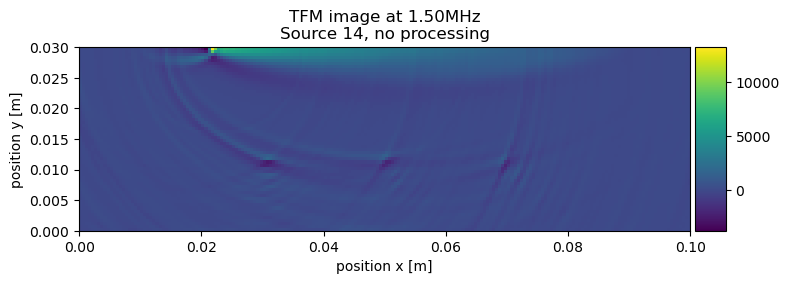

In [98]:
#### source_id = 14
image_event_14 = create_TFM_image(
    observed_data="sc_mesh_homogeneous",
    event_names=[f"array_a_source_{source_id}"],
    calibration_speed=5000,
)


show_tfm_image(
    image_event_14,
    title=f"TFM image at {CENTRAL_FREQUENCY/1e6:.2f}MHz\nSource {source_id}, no processing",
)

## Adding more events to the TFM image

One thing that is a straightforward approach to improve this image, is to illuminate the scatteres from more positions. Let's attempt that to demonstrate multiple simulations being launched:

In [99]:
p.events.list()

['array_a_source_14']

In [100]:
# These are all the events we'll use for imaging from now on out:
event_names_imaging = [
    f"array_a_source_{source_id}" for source_id in np.arange(0, 100, 14)
]

for source_id in np.arange(0, 100, 14):

    source, receivers = array_1.create_salvus_source_receivers(
        source_index=source_id
    )

    event = sn.Event(
        event_name=f"array_a_source_{source_id}",
        sources=source,
        receivers=receivers,
    )

    p += event

# And let's have a look:
p.viz.nb.simulation_setup(
    simulation_configuration="sc_mesh_homogeneous", events=p.events.list()
)

[2025-02-02 18:10:32,972] INFO: An event with name 'array_a_source_14' and identical content already exists in the project. Nothing will be done.


Locating 100 item(s)::   0%|          | 0/100 [00:00<?, ?it/s]

Locating 100 item(s)::   0%|          | 0/100 [00:00<?, ?it/s]

Locating 100 item(s)::   0%|          | 0/100 [00:00<?, ?it/s]

Locating 100 item(s)::   0%|          | 0/100 [00:00<?, ?it/s]

Locating 100 item(s)::   0%|          | 0/100 [00:00<?, ?it/s]

Locating 100 item(s)::   0%|          | 0/100 [00:00<?, ?it/s]

Locating 100 item(s)::   0%|          | 0/100 [00:00<?, ?it/s]

Locating 100 item(s)::   0%|          | 0/100 [00:00<?, ?it/s]

When we have a collection of event names that we wish to simulate, dispatchi0ng them all together is very easy:

In [101]:
p.simulations.launch(
    simulation_configuration="sc_mesh_homogeneous",
    events=event_names_imaging,
    site_name=SITE_NAME,
    ranks_per_job=RANKS,
)

p.simulations.query(block=True)

[2025-02-02 18:10:33,458] INFO: Data for 1 event(s) already exists. They will not be submitted again.


Locating 100 item(s)::   0%|          | 0/100 [00:00<?, ?it/s]

Locating 100 item(s)::   0%|          | 0/100 [00:00<?, ?it/s]

Locating 100 item(s)::   0%|          | 0/100 [00:00<?, ?it/s]

Locating 100 item(s)::   0%|          | 0/100 [00:00<?, ?it/s]

Locating 100 item(s)::   0%|          | 0/100 [00:00<?, ?it/s]

Locating 100 item(s)::   0%|          | 0/100 [00:00<?, ?it/s]

Locating 100 item(s)::   0%|          | 0/100 [00:00<?, ?it/s]

[2025-02-02 18:10:33,690] INFO: Submitting job array with 7 jobs ...


Initializing Jobs and Uploading Files for Individual Jobs:   0%|                                              …

VBox()

True

And just the same, our imaging algorithm can actually take a list of events:

(<Figure size 800x600 with 2 Axes>,
 <Axes: title={'center': 'TFM image at 1.50MHz\nAll sources, no processing'}, xlabel='position x [m]', ylabel='position y [m]'>)

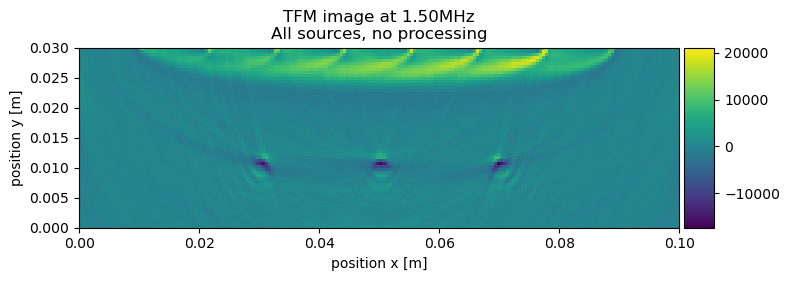

In [102]:
image_all_events = create_TFM_image(
    observed_data="sc_mesh_homogeneous",
    event_names=event_names_imaging,
    calibration_speed=5000,
)


show_tfm_image(
    image_all_events,
    title=f"TFM image at {CENTRAL_FREQUENCY/1e6:.2f}MHz\nAll sources, no processing",
)

## Improving the image by muting direct events

A final thing we'll do to improve this image is to attempt to remove any data that is unrelated to the scatterer. One could do this with defining time windows or manually picking reflected waves. However, since we are in a controlled setting, we can also run this simulation once without scatterers, and subtract those waves from the 'observations'.

We already have a mesh for that:

In [103]:
mesh_homogeneous

We add this simulation as a new configuration, but we do not need new sources and receivers of course!

In [104]:
sc = sn.UnstructuredMeshSimulationConfiguration(
    unstructured_mesh=mesh_homogeneous,
    name="sc_mesh_homogeneous_no_anomaly",
    event_configuration=sn.EventConfiguration(
        wavelet=stf,
        waveform_simulation_configuration=sn.WaveformSimulationConfiguration(
            end_time_in_seconds=end_time
        ),
    ),
)

p += sc

p.simulations.launch(
    simulation_configuration="sc_mesh_homogeneous_no_anomaly",
    events=p.events.list(),
    site_name=SITE_NAME,
    ranks_per_job=RANKS,
)

p.simulations.query(block=True)

Locating 100 item(s)::   0%|          | 0/100 [00:00<?, ?it/s]

Locating 100 item(s)::   0%|          | 0/100 [00:00<?, ?it/s]

Locating 100 item(s)::   0%|          | 0/100 [00:00<?, ?it/s]

Locating 100 item(s)::   0%|          | 0/100 [00:00<?, ?it/s]

Locating 100 item(s)::   0%|          | 0/100 [00:00<?, ?it/s]

Locating 100 item(s)::   0%|          | 0/100 [00:00<?, ?it/s]

Locating 100 item(s)::   0%|          | 0/100 [00:00<?, ?it/s]

Locating 100 item(s)::   0%|          | 0/100 [00:00<?, ?it/s]

[2025-02-02 18:10:53,343] INFO: Submitting job array with 8 jobs ...


Initializing Jobs and Uploading Files for Individual Jobs:   0%|                                              …

VBox()

True

Our imaging algorithm can also take in background data:

(<Figure size 800x600 with 2 Axes>,
 <Axes: title={'center': 'TFM image at 1.50MHz\nAll sources, muted direct'}, xlabel='position x [m]', ylabel='position y [m]'>)

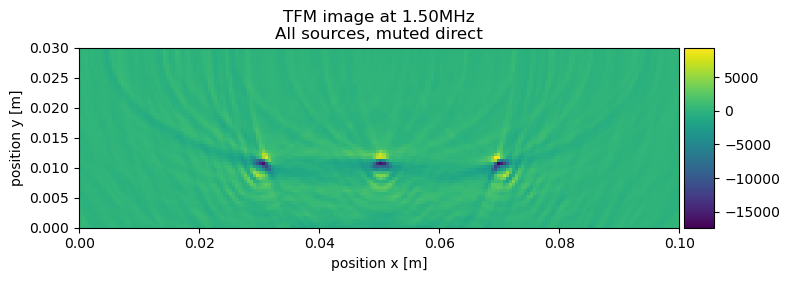

In [105]:
image_all_events_muted_direct = create_TFM_image(
    observed_data="sc_mesh_homogeneous",
    background_data="sc_mesh_homogeneous_no_anomaly",
    event_names=event_names_imaging,
    calibration_speed=5000,
)


show_tfm_image(
    image_all_events_muted_direct,
    title=f"TFM image at {CENTRAL_FREQUENCY/1e6:.2f}MHz\nAll sources, muted direct",
)

(<Figure size 800x600 with 2 Axes>,
 <Axes: title={'center': 'TFM image at 1.5MHz\nAll sources, muted direct'}, xlabel='position x [m]', ylabel='position y [m]'>)

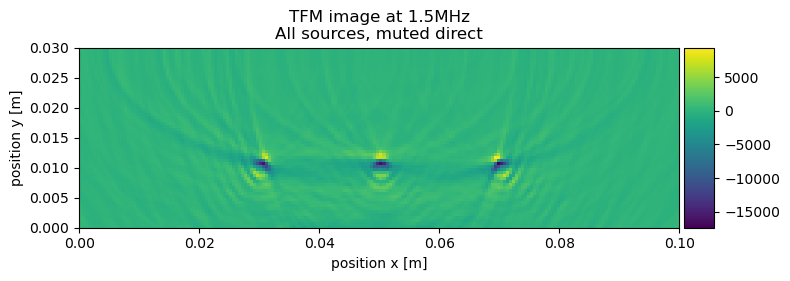

In [106]:
image_all_events_muted_direct = create_TFM_image(
    observed_data="sc_mesh_homogeneous",
    background_data="sc_mesh_homogeneous_no_anomaly",
    event_names=event_names_imaging,
    calibration_speed=5000,
)


show_tfm_image(
    image_all_events_muted_direct,
    title=f"TFM image at {CENTRAL_FREQUENCY/1e6:.1f}MHz\nAll sources, muted direct",
)

## TFM in heterogeneous settings

Now, the case for more advanced imaging algorithms comes when significant unaccounted wave behaviour occurs. This can be various things:

- Strong refractions
- Mode conversions
- Heterogeneous media

Let's see what happens in the case where to material parameters are present. Below we do the same approach, but for a setting in which a slow layer (of possibly water) overlays the material to be investigated.

In [107]:
interface_depth = 0.005

heterogeneous_model = lm.LayeredModel(
    [
        lm.material.acoustic.Velocity.from_params(rho=1450.0, vp=1500.0),
        lm.interface.Hyperplane.at(lm.interface.Depth(interface_depth)),
        sn.material.acoustic.Velocity.from_params(rho=2600.0, vp=5000.0),
    ]
)

# Add absorbing boundaries to layered model
heterogeneous_model_ab = sn.layered_meshing.MeshingProtocol(
    heterogeneous_model,
    ab=salvus.mesh.simple_mesh.basic_mesh.AbsorbingBoundaryParameters(
        free_surface=["y1"],
        number_of_wavelengths=1.5,
        reference_velocity=5000,
        reference_frequency=CENTRAL_FREQUENCY * 2,
    ),
)

mesh_heterogeneous = lm.mesh_from_domain(
    domain=domain,
    model=heterogeneous_model_ab,
    mesh_resolution=sn.MeshResolution(
        reference_frequency=CENTRAL_FREQUENCY * 2, elements_per_wavelength=2
    ),
)

mesh_heterogeneous_scatterers = mesh_heterogeneous.copy()

for scatterer_center in [np.array([x, 0.01]) for x in [0.03, 0.05, 0.07]]:
    distance_from_scatterer = np.linalg.norm(
        mesh_heterogeneous_scatterers.get_element_centroid()
        - scatterer_center,
        axis=1,
    )
    radius = 0.00125
    anomaly = distance_from_scatterer < radius
    mesh_heterogeneous_scatterers.elemental_fields["RHO"] -= (
        anomaly[:, None] * 2400
    )
    mesh_heterogeneous_scatterers.elemental_fields["VP"] -= (
        anomaly[:, None] * 500
    )

mesh_heterogeneous_scatterers

Let's create the new simulations (but not new events, we can re-use those!):

In [108]:
sc = sn.UnstructuredMeshSimulationConfiguration(
    unstructured_mesh=mesh_heterogeneous_scatterers,
    name="sc_mesh_heterogeneous",
    # Event specific configuration.
    event_configuration=sn.EventConfiguration(
        # Source wavelet.
        wavelet=stf,
        waveform_simulation_configuration=sn.WaveformSimulationConfiguration(
            end_time_in_seconds=end_time
        ),
    ),
)

p += sc

And simulate them:

In [109]:
p.simulations.launch(
    simulation_configuration="sc_mesh_heterogeneous",
    events=event_names_imaging,
    site_name=SITE_NAME,
    ranks_per_job=RANKS,
)

p.simulations.query(block=True)

Locating 100 item(s)::   0%|          | 0/100 [00:00<?, ?it/s]

Locating 100 item(s)::   0%|          | 0/100 [00:00<?, ?it/s]

Locating 100 item(s)::   0%|          | 0/100 [00:00<?, ?it/s]

Locating 100 item(s)::   0%|          | 0/100 [00:00<?, ?it/s]

Locating 100 item(s)::   0%|          | 0/100 [00:00<?, ?it/s]

Locating 100 item(s)::   0%|          | 0/100 [00:00<?, ?it/s]

Locating 100 item(s)::   0%|          | 0/100 [00:00<?, ?it/s]

Locating 100 item(s)::   0%|          | 0/100 [00:00<?, ?it/s]

[2025-02-02 18:14:50,890] INFO: Submitting job array with 8 jobs ...


Initializing Jobs and Uploading Files for Individual Jobs:   0%|                                              …

VBox()

True

It's a good thing to have a look awt this data, and see how it differs from the homogeneous case:

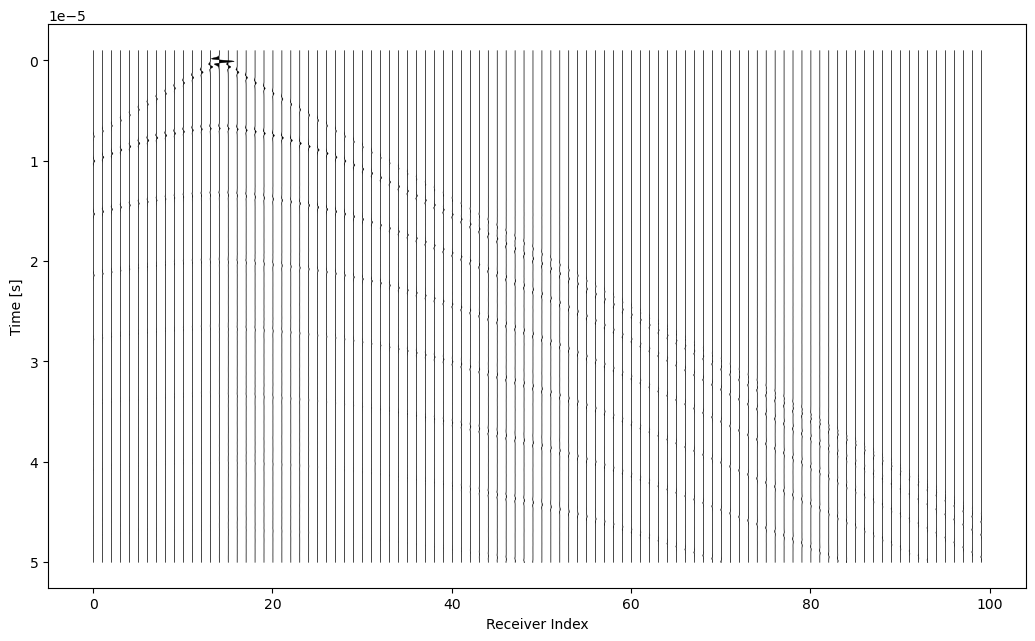

In [110]:
# Note: we only look at one source at a time
source_id = 14

event_data = p.waveforms.get(
    "sc_mesh_heterogeneous", f"array_a_source_{source_id}"
)[0]

event_data.plot(receiver_field="phi", component="A")

Salvus also has built in comparisons:

<Axes: title={'center': 'Event: array_a_source_28 | field: phi | component: A'}, xlabel='Receiver Index', ylabel='Time [s]'>

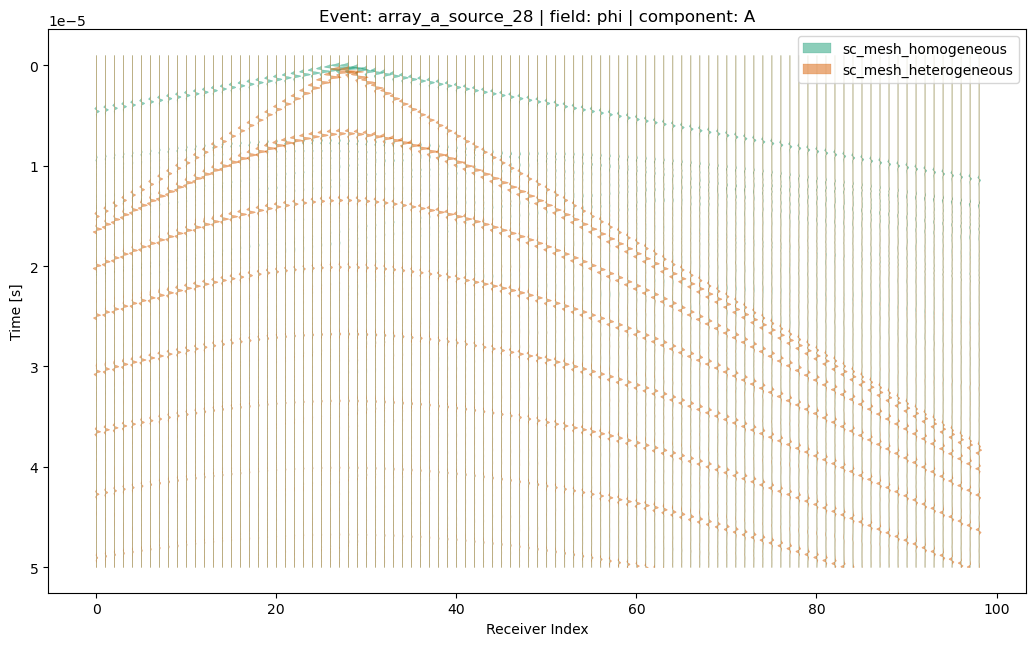

In [111]:
source_id = 28


# Simple filter to not show the source location, as this has very high amplitude
def filter_source_location(receiver):
    return int(receiver.station_code.replace("array_0_x", "")) != source_id


p.viz.custom_gather(
    data=["sc_mesh_homogeneous", "sc_mesh_heterogeneous"],
    event=f"array_a_source_{source_id}",
    receiver_field="phi",
    component="A",
    filter_by=filter_source_location,
)

Let's also create the 'background' data, when no anomaly would be present.

In [112]:
sc = sn.UnstructuredMeshSimulationConfiguration(
    unstructured_mesh=mesh_heterogeneous,
    name="sc_mesh_heterogeneous_no_anomaly",
    event_configuration=sn.EventConfiguration(
        wavelet=stf,
        waveform_simulation_configuration=sn.WaveformSimulationConfiguration(
            end_time_in_seconds=end_time
        ),
    ),
)

p += sc
p.simulations.launch(
    simulation_configuration="sc_mesh_heterogeneous_no_anomaly",
    events=p.events.list(),
    site_name=SITE_NAME,
    ranks_per_job=RANKS,
)

p.simulations.query(block=True)

Locating 100 item(s)::   0%|          | 0/100 [00:00<?, ?it/s]

Locating 100 item(s)::   0%|          | 0/100 [00:00<?, ?it/s]

Locating 100 item(s)::   0%|          | 0/100 [00:00<?, ?it/s]

Locating 100 item(s)::   0%|          | 0/100 [00:00<?, ?it/s]

Locating 100 item(s)::   0%|          | 0/100 [00:00<?, ?it/s]

Locating 100 item(s)::   0%|          | 0/100 [00:00<?, ?it/s]

Locating 100 item(s)::   0%|          | 0/100 [00:00<?, ?it/s]

Locating 100 item(s)::   0%|          | 0/100 [00:00<?, ?it/s]

[2025-02-02 18:17:36,580] INFO: Submitting job array with 8 jobs ...


Initializing Jobs and Uploading Files for Individual Jobs:   0%|                                              …

VBox()

True

And now to create the TFM image in a layered model:

(<Figure size 800x600 with 2 Axes>,
 <Axes: title={'center': 'Heterogeneous model\nTFM image at 1.50MHz\nAll sources, muted direct'}, xlabel='position x [m]', ylabel='position y [m]'>)

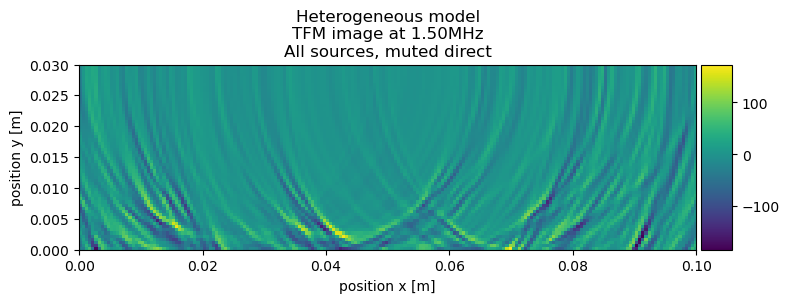

In [118]:
image_all_events_muted_direct = create_TFM_image(
    observed_data="sc_mesh_heterogeneous",
    background_data="sc_mesh_heterogeneous_no_anomaly",
    event_names=event_names_imaging,
    calibration_speed=5000,
)


show_tfm_image(
    image_all_events_muted_direct,
    title=f"Heterogeneous model\nTFM image at {CENTRAL_FREQUENCY/1e6:.2f}"
    + f"MHz\nAll sources, muted direct",
)

The slow layer has completely unfocused the scatterers! We can try to adapt by updating the velocity:

(<Figure size 800x600 with 2 Axes>,
 <Axes: title={'center': 'Heterogeneous model\nTFM image at 1.50MHz\nAll sources, muted direct'}, xlabel='position x [m]', ylabel='position y [m]'>)

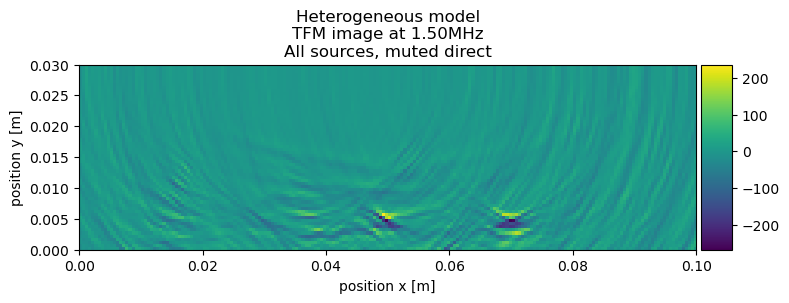

In [124]:
image_all_events_muted_direct = create_TFM_image(
    observed_data="sc_mesh_heterogeneous",
    background_data="sc_mesh_heterogeneous_no_anomaly",
    event_names=event_names_imaging,
    calibration_speed=4100,
)


show_tfm_image(
    image_all_events_muted_direct,
    title=f"Heterogeneous model\nTFM image at {CENTRAL_FREQUENCY/1e6:.2f}"
    + f"MHz\nAll sources, muted direct",
)

Due to the fact that TFM (in this algorithm) can't account for any (2-D, 3-D) structure in the model, the energy gets focused at the wrong vertical location. In even more complicated models, the energy might not focus at all.

Compare the above image with the true location of the scatterers:

In [125]:
mesh_heterogeneous_scatterers

## Full-Waveform Inversion tomography in heterogeneous settings

Full waveform inversion works by minimizing a scoring function. In this case, we'll use the L2 misfit, but many other good choices exist.

In [92]:
# The misfit configuration defines how synthetics are compared to observed data.
p += sn.MisfitConfiguration(
    name="L2_misfit_for_heterogeneous_model",
    # Could be observed data. Here we compare to the synthetic target.
    observed_data="sc_mesh_heterogeneous",
    # Salvus comes with a variety of misfit functions. You can
    # also define your own.
    misfit_function="L2",
    # This is an acoustic simulation so we'll use recordings of phi.
    receiver_field="phi",
)

[2025-01-31 11:08:08,743] INFO: The same misfit_configuration with name `L2_misfit_for_heterogeneous_model` exists already in the project. Nothing will be done.


The following is optional, but adding a region of interest allows us to focus the imaging algorithm only in one part. Ideal when e.g. no scatterers can be present in the water.

In [83]:
roi = (
    mesh_heterogeneous_scatterers.get_element_centroid()[..., 1]
    < y1 - interface_depth * 2
)

mesh_roi = mesh_heterogeneous_scatterers.copy()
fields = [field for field in mesh_roi.elemental_fields]
for field in fields:
    mesh_roi.elemental_fields.pop(field)
mesh_roi.attach_field(
    "region_of_interest",
    np.broadcast_to(roi[:, None], mesh_roi.connectivity.shape),
)

That misfit function, together with the initial model, event selection and various optimization settings, define the inverse problem:

In [91]:
# Now we define the actual inverse problem
p += sn.InverseProblemConfiguration(
    name="inversion_L2",
    # Starting model is the model without scatterers.
    prior_model="sc_mesh_heterogeneous_no_anomaly",
    # The events to use.
    events=event_names_imaging,
    misfit_configuration="L2_misfit_for_heterogeneous_model",
    # What parameters to invert for.
    mapping=sn.Mapping(
        scaling="relative_deviation_from_prior",
        inversion_parameters=["RHO"],
        region_of_interest=mesh_roi,
        # postprocess_model_update = tensor_to_orientation
    ),
    # The inversion method and its settings.
    method=sn.TrustRegion(initial_trust_region_linf=1.0),
    # The misfit configuration we defined above.
    
    # Compress the forward wavefield by subsampling in time.
    wavefield_compression=sn.WavefieldCompression(
        forward_wavefield_sampling_interval=10
    ),
    # Job submission settings.
    job_submission=sn.SiteConfig(site_name=SITE_NAME, ranks_per_job=RANKS),
)

# Now we define the actual inverse problem
p += sn.InverseProblemConfiguration(
    name="inversion_L2_ONE_EVENT",
    # Starting model is the model without scatterers.
    prior_model="sc_mesh_heterogeneous_no_anomaly",
    # The events to use.
    events=["array_a_source_14"],
    misfit_configuration="L2_misfit_for_heterogeneous_model",
    # What parameters to invert for.
    mapping=sn.Mapping(
        scaling="relative_deviation_from_prior",
        inversion_parameters=["RHO"],
        region_of_interest=mesh_roi,
        # postprocess_model_update = tensor_to_orientation
    ),
    # The inversion method and its settings.
    method=sn.TrustRegion(initial_trust_region_linf=1.0),
    # The misfit configuration we defined above.
    
    # Compress the forward wavefield by subsampling in time.
    wavefield_compression=sn.WavefieldCompression(
        forward_wavefield_sampling_interval=10
    ),
    # Job submission settings.
    job_submission=sn.SiteConfig(site_name=SITE_NAME, ranks_per_job=RANKS),
)

[2025-01-31 11:08:05,405] INFO: The project already contains an inverse problem configuration with name `inversion_L2` and the same input arguments. Nothing will be done.


You can always update the site configuration to use more or less resources during optimization:

In [90]:
event_names_imaging[1]

'array_a_source_14'

In [87]:
p.inversions.set_job_submission_configuration(
    "inversion_L2", sn.SiteConfig(site_name=SITE_NAME, ranks_per_job=RANKS)
)

Finally, we can now iterate in this tomography. Salvus fully takes care of dispatching all simulations, ocmparing data, and updating the model:

In [96]:
# Lastly we perform two iterations, and have a look at the results.
for i in range(20):
    p.inversions.iterate(
        inverse_problem_configuration="inversion_L2_ONE_EVENT",
        timeout_in_seconds=360,
        ping_interval_in_seconds=10,
        delete_disposable_files="all",
    )

[2025-01-31 11:16:21,948] INFO: Resuming iteration #9.

[2025-01-31 11:16:21,948] INFO: Processing task `gradient`
[2025-01-31 11:16:21,996] INFO: 1 events have already been submitted. They will not be submitted again.
[2025-01-31 11:16:22,197] INFO: 
Iteration 9: Number of events: 1	 chi = 0.0006899897922628221	 ||g|| = 0.4788442550537994
pred = -7.927035406958129e-05	ared = -7.698285085931276e-05	norm_update = 0.00045685385413129115	tr_radius = 0.0012360988405301643
[2025-01-31 11:16:22,424] INFO: 1 new tasks have been issued.
[2025-01-31 11:16:22,424] INFO: Processing task `misfit`


Locating 100 item(s)::   0%|          | 0/100 [00:00<?, ?it/s]

[2025-01-31 11:16:22,507] INFO: Submitting job ...
[2025-01-31 11:16:22,651] INFO: Launched simulations for 1 events. Please check again to see if they are finished.
[2025-01-31 11:16:22,652] INFO: Some tasks of iteration #9 are still running. Please check again later.
[2025-01-31 11:16:32,693] INFO: Processing task `misfit`
[2025-01-31 11:16:33,158] INFO: 
old misfit control group: 0.0006899897922628221
new misfit control group: 0.0006244722269484174
predicted reduction control group: -5.1762531250564193e-05
actual reduction control group: -6.551756531440473e-05
1 out of 1 event(s) improved the misfit.
[2025-01-31 11:16:33,159] INFO: 
Model update accepted.
[2025-01-31 11:16:33,159] INFO: 1 new tasks have been issued.
[2025-01-31 11:16:33,159] INFO: Processing task `finalize_iteration`
[2025-01-31 11:16:33,214] INFO: ... searching for obsolete files in project_04_1000000/INVERSIONS/inversion_L2_ONE_EVENT/00009
[2025-01-31 11:16:33,271] INFO: Freed up 4.8 MB of space.
[2025-01-31 11:16

Locating 100 item(s)::   0%|          | 0/100 [00:00<?, ?it/s]

[2025-01-31 11:16:44,084] INFO: Submitting job ...
[2025-01-31 11:16:44,213] INFO: Launched simulations for 1 events. Please check again to see if they are finished.
[2025-01-31 11:16:44,214] INFO: Some tasks of iteration #10 are still running. Please check again later.
[2025-01-31 11:16:54,253] INFO: Processing task `misfit`
[2025-01-31 11:16:54,708] INFO: 
old misfit control group: 0.0006244722269484174
new misfit control group: 0.0005495924047159151
predicted reduction control group: -7.717538711448093e-05
actual reduction control group: -7.487982223250227e-05
1 out of 1 event(s) improved the misfit.
[2025-01-31 11:16:54,709] INFO: 
Model update accepted.
[2025-01-31 11:16:54,709] INFO: 1 new tasks have been issued.
[2025-01-31 11:16:54,709] INFO: Processing task `finalize_iteration`
[2025-01-31 11:16:54,766] INFO: ... searching for obsolete files in project_04_1000000/INVERSIONS/inversion_L2_ONE_EVENT/00010
[2025-01-31 11:16:54,820] INFO: Freed up 4.8 MB of space.
[2025-01-31 11:16

Locating 100 item(s)::   0%|          | 0/100 [00:00<?, ?it/s]

[2025-01-31 11:17:05,641] INFO: Submitting job ...
[2025-01-31 11:17:05,771] INFO: Launched simulations for 1 events. Please check again to see if they are finished.
[2025-01-31 11:17:05,772] INFO: Some tasks of iteration #11 are still running. Please check again later.
[2025-01-31 11:17:15,812] INFO: Processing task `misfit`
[2025-01-31 11:17:16,287] INFO: 
old misfit control group: 0.0005495924047159151
new misfit control group: 0.0005046826166303106
predicted reduction control group: -5.7150697636246725e-05
actual reduction control group: -4.4909788085604465e-05
1 out of 1 event(s) improved the misfit.
[2025-01-31 11:17:16,288] INFO: 
Model update accepted.
[2025-01-31 11:17:16,288] INFO: 1 new tasks have been issued.
[2025-01-31 11:17:16,288] INFO: Processing task `finalize_iteration`
[2025-01-31 11:17:16,348] INFO: ... searching for obsolete files in project_04_1000000/INVERSIONS/inversion_L2_ONE_EVENT/00011
[2025-01-31 11:17:16,402] INFO: Freed up 4.8 MB of space.
[2025-01-31 11:

Locating 100 item(s)::   0%|          | 0/100 [00:00<?, ?it/s]

[2025-01-31 11:17:27,217] INFO: Submitting job ...
[2025-01-31 11:17:27,359] INFO: Launched simulations for 1 events. Please check again to see if they are finished.
[2025-01-31 11:17:27,360] INFO: Some tasks of iteration #12 are still running. Please check again later.
[2025-01-31 11:17:37,400] INFO: Processing task `misfit`
[2025-01-31 11:17:37,871] INFO: 
old misfit control group: 0.0005046826166303106
new misfit control group: 0.00046875668669548484
predicted reduction control group: -4.958031504663192e-05
actual reduction control group: -3.592592993482578e-05
1 out of 1 event(s) improved the misfit.
[2025-01-31 11:17:37,871] INFO: 
Model update accepted.
[2025-01-31 11:17:37,872] INFO: 1 new tasks have been issued.
[2025-01-31 11:17:37,872] INFO: Processing task `finalize_iteration`
[2025-01-31 11:17:37,926] INFO: ... searching for obsolete files in project_04_1000000/INVERSIONS/inversion_L2_ONE_EVENT/00012
[2025-01-31 11:17:37,977] INFO: Freed up 4.8 MB of space.
[2025-01-31 11:1

Locating 100 item(s)::   0%|          | 0/100 [00:00<?, ?it/s]

[2025-01-31 11:17:48,781] INFO: Submitting job ...
[2025-01-31 11:17:48,907] INFO: Launched simulations for 1 events. Please check again to see if they are finished.
[2025-01-31 11:17:48,908] INFO: Some tasks of iteration #13 are still running. Please check again later.
[2025-01-31 11:17:58,947] INFO: Processing task `misfit`
[2025-01-31 11:17:59,420] INFO: 
old misfit control group: 0.00046875668669548484
new misfit control group: 0.0004511590743532411
predicted reduction control group: -3.167088586030943e-05
actual reduction control group: -1.7597612342243752e-05
1 out of 1 event(s) improved the misfit.
[2025-01-31 11:17:59,420] INFO: 
Model update accepted.
[2025-01-31 11:17:59,421] INFO: 1 new tasks have been issued.
[2025-01-31 11:17:59,421] INFO: Processing task `finalize_iteration`
[2025-01-31 11:17:59,481] INFO: ... searching for obsolete files in project_04_1000000/INVERSIONS/inversion_L2_ONE_EVENT/00013
[2025-01-31 11:17:59,535] INFO: Freed up 4.8 MB of space.
[2025-01-31 11:

Locating 100 item(s)::   0%|          | 0/100 [00:00<?, ?it/s]

[2025-01-31 11:18:10,346] INFO: Submitting job ...
[2025-01-31 11:18:10,474] INFO: Launched simulations for 1 events. Please check again to see if they are finished.
[2025-01-31 11:18:10,475] INFO: Some tasks of iteration #14 are still running. Please check again later.
[2025-01-31 11:18:20,516] INFO: Processing task `misfit`
[2025-01-31 11:18:20,978] INFO: 
old misfit control group: 0.0004511590743532411
new misfit control group: 0.00043298205433672685
predicted reduction control group: -2.8407057240113193e-05
actual reduction control group: -1.8177020016514243e-05
1 out of 1 event(s) improved the misfit.
[2025-01-31 11:18:20,979] INFO: 
Model update accepted.
[2025-01-31 11:18:20,979] INFO: 1 new tasks have been issued.
[2025-01-31 11:18:20,979] INFO: Processing task `finalize_iteration`
[2025-01-31 11:18:21,036] INFO: ... searching for obsolete files in project_04_1000000/INVERSIONS/inversion_L2_ONE_EVENT/00014
[2025-01-31 11:18:21,088] INFO: Freed up 4.8 MB of space.
[2025-01-31 11

Locating 100 item(s)::   0%|          | 0/100 [00:00<?, ?it/s]

[2025-01-31 11:18:31,911] INFO: Submitting job ...
[2025-01-31 11:18:32,041] INFO: Launched simulations for 1 events. Please check again to see if they are finished.
[2025-01-31 11:18:32,042] INFO: Some tasks of iteration #15 are still running. Please check again later.
[2025-01-31 11:18:42,084] INFO: Processing task `misfit`
[2025-01-31 11:18:42,593] INFO: 
old misfit control group: 0.00043298205433672685
new misfit control group: 0.0004252416093664614
predicted reduction control group: -6.2560705749955884e-06
actual reduction control group: -7.740444970265445e-06
1 out of 1 event(s) improved the misfit.
[2025-01-31 11:18:42,593] INFO: 
Model update accepted.
[2025-01-31 11:18:42,594] INFO: 1 new tasks have been issued.
[2025-01-31 11:18:42,594] INFO: Processing task `finalize_iteration`
[2025-01-31 11:18:42,653] INFO: ... searching for obsolete files in project_04_1000000/INVERSIONS/inversion_L2_ONE_EVENT/00015
[2025-01-31 11:18:42,708] INFO: Freed up 4.8 MB of space.
[2025-01-31 11:

KeyboardInterrupt: 

In [97]:
p.viz.nb.inversion(inverse_problem_configuration="inversion_L2")

In [85]:
# I want to get the (absolute) model at the end of an inversion...

# This gets only the relative model
# p.inversions.get_model("inversion_L2", 1) 

# And the following seems like way too much work.
iteration = p.inversions.get_iteration("inversion_L2", 1)

# This is the name of the final model of iteration 1
iteration.get_final_model()

sc = p.entities.get(
    entity_name="inversion_L2_" + iteration.get_final_model(),
    entity_type="simulation_configuration"
)

# This is where the model is stored
sc.hdf5_filename

sn.UnstructuredMesh.from_h5(PROJECT_NAME + "/" + sc.hdf5_filename)

## Improving FWI by smoothing and multiparameter inversion

We can improve the FWI iamge a bit by adding smoothing, and also inverting for VP:

In [102]:
# Look for comments to see what changed.
p += sn.InverseProblemConfiguration(
    # To run another inversion in the same project, this one needs a new name.
    name="inversion_L2_with_smoothing",
    prior_model="sc_mesh_homogeneous_no_anomaly",
    events=event_names_imaging,
    mapping=sn.Mapping(
        scaling="relative_deviation_from_prior",
        # VP was added here!
        inversion_parameters=["RHO", "VP"],
        region_of_interest=mesh_roi,
    ),
    # This was added!
    preconditioner=sn.ConstantSmoothing({"RHO": 0.003, "VP": 0.003}),
    method=sn.TrustRegion(initial_trust_region_linf=1.0),
    misfit_configuration="L2_misfit_for_heterogeneous_model",
    wavefield_compression=sn.WavefieldCompression(
        forward_wavefield_sampling_interval=10
    ),
    job_submission=sn.SiteConfig(site_name=SITE_NAME, ranks_per_job=RANKS),
)

[2025-01-31 11:36:44,772] INFO: The project already contains an inverse problem configuration with name `inversion_L2_with_smoothing` and the same input arguments. Nothing will be done.


In [104]:
# Lastly we perform two iterations, and have a look at the results.
for i in range(30):
    p.inversions.iterate(
        inverse_problem_configuration="inversion_L2_with_smoothing",
        timeout_in_seconds=360,
        ping_interval_in_seconds=10,
        delete_disposable_files=None,
    )

[2025-01-31 11:54:47,527] INFO: Resuming iteration #2.

[2025-01-31 11:54:47,527] INFO: Processing task `misfit`
[2025-01-31 11:54:50,548] INFO: 
old misfit control group: 0.004971953639365976
new misfit control group: 0.0049719540311255785
predicted reduction control group: -1.540752730989073e-11
actual reduction control group: 3.917596021890679e-10
3 out of 8 event(s) improved the misfit.
[2025-01-31 11:54:50,548] INFO: 
Model update rejected.
[2025-01-31 11:54:50,888] INFO: 1 new tasks have been issued.
[2025-01-31 11:54:50,888] INFO: Processing task `misfit`


Locating 100 item(s)::   0%|          | 0/100 [00:00<?, ?it/s]

Locating 100 item(s)::   0%|          | 0/100 [00:00<?, ?it/s]

Locating 100 item(s)::   0%|          | 0/100 [00:00<?, ?it/s]

Locating 100 item(s)::   0%|          | 0/100 [00:00<?, ?it/s]

Locating 100 item(s)::   0%|          | 0/100 [00:00<?, ?it/s]

Locating 100 item(s)::   0%|          | 0/100 [00:00<?, ?it/s]

Locating 100 item(s)::   0%|          | 0/100 [00:00<?, ?it/s]

Locating 100 item(s)::   0%|          | 0/100 [00:00<?, ?it/s]

[2025-01-31 11:54:51,218] INFO: Submitting job array with 8 jobs ...

[2025-01-31 11:54:51,454] INFO: Launched simulations for 8 events. Please check again to see if they are finished.
[2025-01-31 11:54:51,457] INFO: Some tasks of iteration #2 are still running. Please check again later.


KeyboardInterrupt: 

In [105]:
p.viz.nb.inversion(inverse_problem_configuration="inversion_L2_with_smoothing")

In [56]:
import xarray as xr

import tqdm.autonotebook as tqdm

# As one event might also record other data than pressure in Salvus, let's first select only pressure
pressure_data = event_data.get_waveform_data_xarray(receiver_field="phi")

def alt_tfm(
    event_names: list[str],
    observed_data: str,
    pixel_resolution: float = 0.0005,
    calibration_speed: float = 5000,
    averaging_length: float | None = None,
    background_data: str | None = None,
    receiver_field: str = "phi",
    samples: int = 5,
    noise: float = 1.0
):

    # Create image grid from domain and resolution
    x0, x1 = domain.bounds.hc["x"]
    y0, y1 = domain.bounds.vc["y"]
    _x = np.linspace(x0, x1, int((x1 - x0) / pixel_resolution))
    _y = np.linspace(y0, y1, int((y1 - y0) / pixel_resolution))
    pixel_x, pixel_y = np.meshgrid(_x, _y)

    

    # Get source and receiver locations
    rec_x, rec_y = (
        p.waveforms.get(observed_data, event_names[0])[0]
        .get_waveform_data_xarray(receiver_field=receiver_field)
        .location
    ).T

    # Shape: (nrec, ny, nx)
    distance_pixels_to_receivers = (
        (rec_x[..., None, None] - pixel_x[None, ...]) ** 2
        + (rec_y[..., None, None] - pixel_y[None, ...]) ** 2
    ) ** 0.5

    tfm_images = []

    for _ in tqdm.trange(samples):
        # Create empty image
        tfm_image = np.zeros_like(pixel_x)
    
        for event_name in event_names:
    
            # Get observed data to process into image
            event_data = p.waveforms.get(observed_data, event_name)[0]
            pressure_data = event_data.get_waveform_data_xarray(
                receiver_field=receiver_field
            )

            pressure_data += noise* np.random.randn(*pressure_data.shape)
    
            # Obtain background data if passed, and subtract from observed
            if background_data is not None:
                event_data_mute = p.waveforms.get(background_data, event_name)[0]
    
                # This allows us to isolate the data from the scattering
                pressure_data -= event_data_mute.get_waveform_data_xarray(
                    receiver_field=receiver_field
                )
    
            # Use a window to smooth out the data if passed
            if averaging_length is not None:
                pressure_data = pressure_data.rolling(
                    time=averaging_length, center=True
                ).max()
    
            # Get source positions
            src_x = event_data.sources[0].point[0]
            src_y = y1
    
            # Compute distances from all sources to all pixels
            distance_pixels_to_source = (
                (src_x - pixel_x) ** 2 + (src_y - pixel_y) ** 2
            ) ** 0.5
    
            # Compute distances (and time of flight) from all sources to all receivers, via every pixel.
            # This is a pretty large matrix!
            total_distances = (
                distance_pixels_to_receivers + distance_pixels_to_source[None, ...]
            )
            expected_time_of_flight = total_distances / calibration_speed
    
            # Make sure all data is in the simulation. This could be dropped but would require more logic.
            assert expected_time_of_flight.max() < end_time
    
            # Now we select the expected time of flights (whatever shape that might
            # be) along the time dimension using nearest
            data = pressure_data.sel(
                time=expected_time_of_flight.flatten(), method="nearest"
            )
    
            # And extract only those for their specific source by using diagonal. Otherwise
            # every time window (for every source-rec-pixel combination) would be present
            image = (
                np.diagonal(
                    data.data.reshape(
                        (
                            expected_time_of_flight.shape[0],
                            *expected_time_of_flight.shape,
                        )
                    ),
                    axis1=0,
                    axis2=1,
                    # And finally here sum over all source-receivers, so that we're left with the final amplitude per pixel.
                )
            ).sum(axis=-1)
    
            tfm_image += image
        tfm_images.append(tfm_image)

    return np.array(tfm_images)




In [74]:
source_id = 14
image_event_14_stochastic = alt_tfm(
    observed_data="sc_mesh_homogeneous",
    background_data="sc_mesh_homogeneous_no_anomaly",
    event_names=[f"array_a_source_{source_id}"],
    calibration_speed=5000,
    samples=1000,
    noise=100
)

  0%|          | 0/1000 [00:00<?, ?it/s]

(<Figure size 800x600 with 2 Axes>,
 <Axes: title={'center': 'TFM image at 1.0MHz\nSource 14, no processing'}, xlabel='position x [m]', ylabel='position y [m]'>)

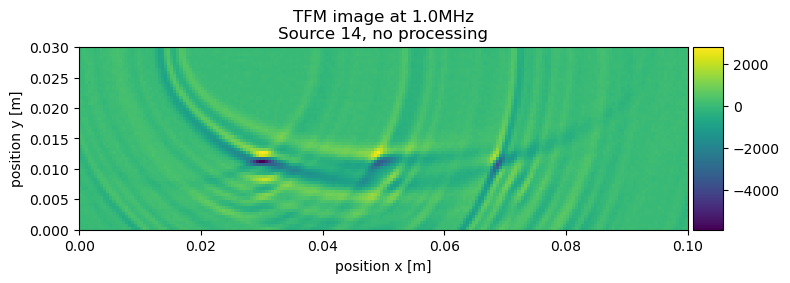

In [75]:
show_tfm_image(
    image_event_14_stochastic.mean(axis=0),
    title=f"TFM image at {CENTRAL_FREQUENCY/1e6:.1f}MHz\nSource {source_id}, no processing"
)

(<Figure size 800x600 with 2 Axes>,
 <Axes: title={'center': 'TFM image at 1.0MHz\nSource 14, no processing'}, xlabel='position x [m]', ylabel='position y [m]'>)

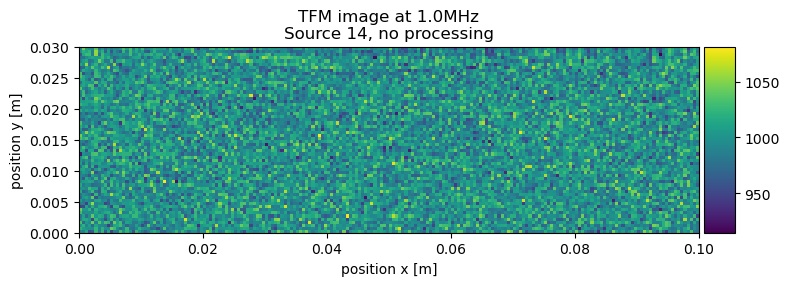

In [76]:
show_tfm_image(
    image_event_14_stochastic.std(axis=0),
    title=f"TFM image at {CENTRAL_FREQUENCY/1e6:.1f}MHz\nSource {source_id}, no processing"
)

In [108]:
mesh2 = sn.UnstructuredMesh.from_exodus("./Mesh.e")

In [110]:
mesh2.attach_field("RADIUS", mesh2.get_element_centroid_radius())

In [111]:
mesh2